# Installing Required Libraries

In [ ]:
!pip install torch torchvision cleanvision scikit-learn matplotlib numpy onnx opencv-python-headless pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16

# Importing Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
import shutil
from cleanvision import Imagelab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameter Tuning

In [ ]:
image_size = 180
num_classes = 12
num_epochs = 10
batch_size = 32
learning_rate = 0.001

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Defining Directories

In [ ]:
# Directories
train_dir = "/content/drive/MyDrive/I2V/cleaned_train"
val_dir = "/content/drive/MyDrive/I2V/vehicle_dataset/val"
output_dir = "/content/drive/MyDrive/I2V/Resnet"
# metrics_file = os.path.join(output_dir, "training_metrics.txt")
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Load pre-trained ResNet-50

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False  # Freeze all by default
for param in model.layer4.parameters():  # Unfreeze layer4 (last block)
    param.requires_grad = True
for param in model.fc.parameters():     # Unfreeze fc
    param.requires_grad = True

# Move to device
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.8MB/s]


In [ ]:
# Loss and optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Initialize metrics


In [ ]:
# Function to compute mAP (simplified for multi-class classification)
def compute_map(true_labels, pred_probs, num_classes):
    # Convert to binary relevance (one-hot encoded true labels)
    true_labels_one_hot = np.zeros((len(true_labels), num_classes))
    for i, label in enumerate(true_labels):
        true_labels_one_hot[i, label] = 1

    # Compute Average Precision per class and mean
    average_precisions = []
    for c in range(num_classes):
        true_c = true_labels_one_hot[:, c]
        scores_c = pred_probs[:, c]
        if true_c.sum() == 0:  # Skip if no positive instances
            continue
        sorted_indices = np.argsort(scores_c)[::-1]
        true_c_sorted = true_c[sorted_indices]
        precision_at_k = np.cumsum(true_c_sorted) / (np.arange(len(true_c_sorted)) + 1)
        ap = np.sum(precision_at_k * true_c_sorted) / max(true_c.sum(), 1)
        average_precisions.append(ap)

    return np.mean(average_precisions) if average_precisions else 0.0

In [ ]:
def compute_metrics(true_labels, pred_labels, pred_probs, epoch, save_file):
    accuracy = 100 * (true_labels == pred_labels).mean()
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    m_ap = compute_map(true_labels, pred_probs, num_classes)
    cm = confusion_matrix(true_labels, pred_labels)

    metrics_str = (
        f"Validation Metrics - Epoch {epoch+1}:\n"
        f"Accuracy: {accuracy:.2f}%\n"
        f"Precision: {precision:.4f}\n"
        f"Recall: {recall:.4f}\n"
        f"F1 Score: {f1:.4f}\n"
        f"mAP: {m_ap:.4f}\n"
        f"Confusion Matrix:\n{cm}\n\n"
    )
    print(metrics_str)

    with open(save_file, 'a') as f:
        f.write(metrics_str)

    return accuracy, cm

In [ ]:
# Training loop with learning curves
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

In [ ]:
# Initialize metrics file
with open(os.path.join(output_dir, "training_metrics.txt"), 'w') as f:
    f.write("Training Metrics Log\n\n")

In [ ]:
metrics_file = "/content/drive/MyDrive/I2V/Resnet/training_metrics.txt"

In [ ]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_true = []
    val_pred = []
    val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            _, predicted = torch.max(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(predicted.cpu().numpy())
            val_probs.extend(probs)

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_acc, cm = compute_metrics(np.array(val_true), np.array(val_pred), np.array(val_probs), epoch, metrics_file)
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, os.path.join(output_dir, "resnet_best.pt"))
        print(f"Saved best model with Validation Accuracy: {val_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Train Loss: 0.6584
Validation Metrics - Epoch 1:
Accuracy: 71.11%
Precision: 0.7939
Recall: 0.7111
F1 Score: 0.7337
mAP: 0.7301
Confusion Matrix:
[[105   0   1   6  17   0   0   2   0   0   6   0]
 [  1  34   0   0   8   0   0  26   0   0   0   0]
 [  5   0  40  14   3   0   1   0   0   0   5   3]
 [  3   0   0  26   1   0   1   3   0   1   0   0]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  8   0   1   1   8   0  73   0   0   2   9   0]
 [  0   1   0   1   9   0   0  57   0   1   0   0]
 [  1   0   0   0  10   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 15   0   6   5   6   0   2   0   0   4 117   2]
 [  6   0   1   7   1   0   3   0   0   0   2  83]]


Validation Loss: 1.0413
Saved best model with Validation Accuracy: 71.11%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/10], Train Loss: 0.5392
Validation Metrics - Epoch 2:
Accuracy: 79.61%
Precision: 0.8283
Recall: 0.7961
F1 Score: 0.7981
mAP: 0.8241
Confusion Matrix:
[[123   0   2   2   0   0   0   2   0   0   8   0]
 [  0  66   0   0   0   0   0   3   0   0   0   0]
 [  6   0  57   1   0   0   1   0   0   1   4   1]
 [  4   1   2  25   0   0   0   0   0   0   2   1]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  8   1   1   2   3   0  69   0   0   9   7   2]
 [  1   1   0   0   0   0   0  67   0   0   0   0]
 [  2   4   0   0   5   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 11   0  19   2   0   0   0   0   0   8 116   1]
 [  7   0   2   4   0   0   3   0   0   0  10  77]]


Validation Loss: 0.6390
Saved best model with Validation Accuracy: 79.61%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/10], Train Loss: 0.4255
Validation Metrics - Epoch 3:
Accuracy: 83.92%
Precision: 0.8551
Recall: 0.8392
F1 Score: 0.8427
mAP: 0.9099
Confusion Matrix:
[[114   0   1   3   0   0   2   4   0   0  13   0]
 [  0  61   0   0   0   0   0   8   0   0   0   0]
 [  1   0  54   2   1   1   1   0   0   0  10   1]
 [  0   1   0  28   0   0   0   2   0   0   4   0]
 [  0   0   0   0   5   0   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   1   1   2   0   0  87   0   0   4   5   2]
 [  0   0   0   0   0   0   0  69   0   0   0   0]
 [  1   0   0   0   0   0   2   1   6   0   2   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  5   0   9   4   0   0   8   1   0   5 123   2]
 [  1   0   4   3   0   0   1   0   0   0   3  91]]


Validation Loss: 0.5384
Saved best model with Validation Accuracy: 83.92%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/10], Train Loss: 0.3379
Validation Metrics - Epoch 4:
Accuracy: 82.75%
Precision: 0.8421
Recall: 0.8275
F1 Score: 0.8284
mAP: 0.8197
Confusion Matrix:
[[121   0   0   1   1   0   1   1   0   0  10   2]
 [  0  69   0   0   0   0   0   0   0   0   0   0]
 [  2   0  44  14   0   0   1   0   0   0   8   2]
 [  2   0   0  28   0   0   0   2   0   0   2   1]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  3   0   1   9   2   0  82   0   0   0   2   3]
 [  2   9   0   0   0   0   0  57   1   0   0   0]
 [  1   3   0   0   1   0   1   0   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  9   0   9   4   2   1   8   0   0   0 118   6]
 [  0   0   0   3   0   0   0   0   0   0   0 100]]


Validation Loss: 0.6454


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/10], Train Loss: 0.2854
Validation Metrics - Epoch 5:
Accuracy: 86.93%
Precision: 0.8767
Recall: 0.8693
F1 Score: 0.8702
mAP: 0.8511
Confusion Matrix:
[[124   0   0   3   0   0   0   3   0   0   6   1]
 [  0  63   0   0   0   0   0   6   0   0   0   0]
 [  2   0  52   4   0   0   2   0   0   0   8   3]
 [  0   0   0  30   0   0   0   1   0   0   4   0]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0]
 [  3   0   1   2   2   0  84   0   0   1   6   3]
 [  1   0   0   0   0   0   0  67   1   0   0   0]
 [  0   0   0   0   1   0   0   0  10   0   1   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  5   0   9   7   0   0   2   0   0   0 129   5]
 [  0   0   1   4   0   0   0   0   0   0   0  98]]


Validation Loss: 0.5098
Saved best model with Validation Accuracy: 86.93%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/10], Train Loss: 0.2958
Validation Metrics - Epoch 6:
Accuracy: 84.18%
Precision: 0.8569
Recall: 0.8418
F1 Score: 0.8402
mAP: 0.9309
Confusion Matrix:
[[129   0   0   0   2   0   0   1   0   0   5   0]
 [  0  43   0   0   0   0   0  24   2   0   0   0]
 [  4   0  56   2   1   1   1   0   0   0   4   2]
 [  2   1   0  28   0   0   0   2   0   0   2   0]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  9   0   1   2   1   0  84   0   0   1   2   2]
 [  0   0   0   0   0   0   0  68   1   0   0   0]
 [  0   0   0   0   1   0   0   0  10   0   1   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 13   0   9   4   0   0   7   0   1   1 116   6]
 [  2   0   0   0   0   0   0   0   0   0   0 101]]


Validation Loss: 0.5653


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [7/10], Train Loss: 0.2801
Validation Metrics - Epoch 7:
Accuracy: 86.93%
Precision: 0.8773
Recall: 0.8693
F1 Score: 0.8705
mAP: 0.8568
Confusion Matrix:
[[127   0   2   2   1   0   0   1   0   0   4   0]
 [  0  64   0   0   0   0   0   3   2   0   0   0]
 [  2   0  62   0   1   1   0   0   0   0   4   1]
 [  3   0   1  28   0   0   0   0   0   0   3   0]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   2   1   3   1  92   0   0   0   2   1]
 [  1   4   0   0   0   0   0  63   1   0   0   0]
 [  1   0   0   0   0   0   1   0   9   0   1   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  7   0  13   4   1   0   7   0   1   0 117   7]
 [  2   0   1   1   0   1   5   0   0   0   0  93]]


Validation Loss: 0.6044


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [8/10], Train Loss: 0.2422
Validation Metrics - Epoch 8:
Accuracy: 84.71%
Precision: 0.8640
Recall: 0.8471
F1 Score: 0.8506
mAP: 0.9267
Confusion Matrix:
[[107   1   0   4   4   0   5   2   0   0  14   0]
 [  0  64   0   0   0   0   0   2   3   0   0   0]
 [  0   0  56   2   1   0   1   0   0   0  11   0]
 [  0   0   2  29   0   0   0   1   0   0   3   0]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  0   1   1   1   4   0  92   0   0   0   2   1]
 [  0   3   0   0   0   0   0  65   1   0   0   0]
 [  0   0   0   0   0   0   0   0  11   0   1   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  3   1   6   4   3   0  11   0   0   0 128   1]
 [  0   0   1   2   0   0   8   0   0   0   5  87]]


Validation Loss: 0.7893


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [9/10], Train Loss: 0.2649
Validation Metrics - Epoch 9:
Accuracy: 85.23%
Precision: 0.8601
Recall: 0.8523
F1 Score: 0.8527
mAP: 0.8963
Confusion Matrix:
[[113   0   1   0   0   0   4   3   0   0  16   0]
 [  0  59   0   0   0   0   0   9   0   0   1   0]
 [  1   0  63   0   1   0   0   1   0   0   4   1]
 [  0   0   2  23   0   0   1   3   0   0   6   0]
 [  2   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  2   0   2   2   0   0  89   0   0   0   7   0]
 [  0   0   0   0   0   0   0  68   1   0   0   0]
 [  3   0   0   1   0   0   1   0   7   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  6   0  13   1   0   0   2   1   1   0 131   2]
 [  0   0   2   0   0   0   3   0   0   0   7  91]]


Validation Loss: 0.6816


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [10/10], Train Loss: 0.2119
Validation Metrics - Epoch 10:
Accuracy: 85.36%
Precision: 0.8604
Recall: 0.8536
F1 Score: 0.8540
mAP: 0.9143
Confusion Matrix:
[[125   0   0   1   0   0   0   2   0   0   9   0]
 [  1  64   0   0   0   0   0   4   0   0   0   0]
 [  1   0  50   5   1   2   1   0   0   0   8   3]
 [  2   0   1  23   0   0   1   1   0   0   5   2]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  5   1   0   1   1   1  86   0   0   1   2   4]
 [  0   3   0   1   0   0   0  63   1   1   0   0]
 [  0   2   0   0   1   0   1   0   6   0   1   1]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [  7   0   8   3   0   0   4   0   0   3 127   5]
 [  1   0   2   0   0   1   0   0   0   0   0  99]]


Validation Loss: 0.5972


In [ ]:
len(val_losses)

11

# Visualizing Performance Metrics

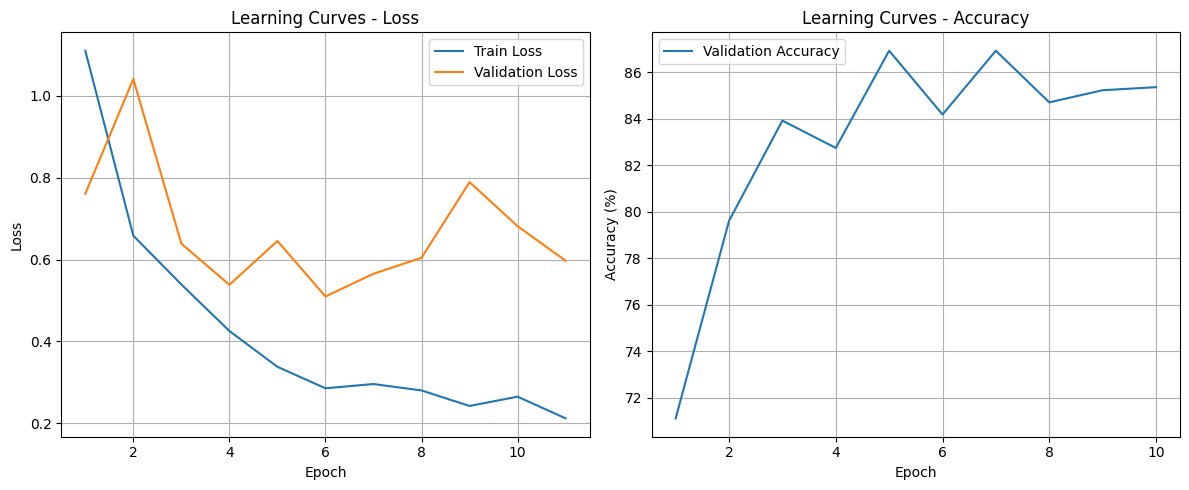

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves - Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curves - Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "learning_curves.png"))
plt.show()

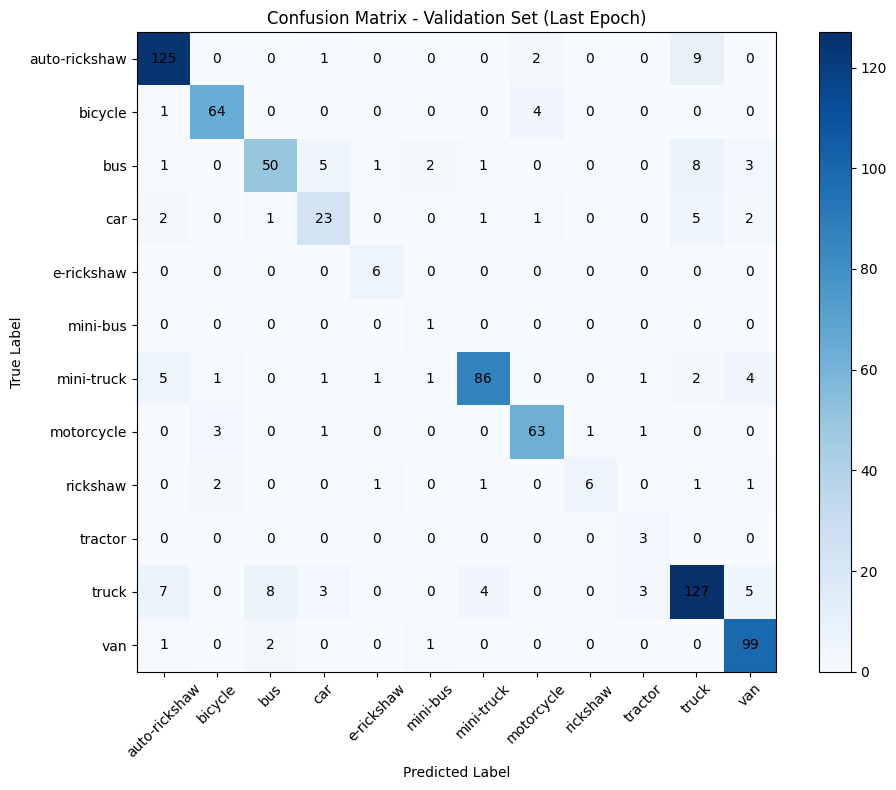

Training complete. Best Validation Accuracy: 86.93%


In [ ]:
# Plot confusion matrix (using the last epoch's validation CM)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set (Last Epoch)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, val_dataset.classes, rotation=45)
plt.yticks(tick_marks, val_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

print(f"Training complete. Best Validation Accuracy: {best_val_acc:.2f}%")

# Saving Model


In [ ]:
# Export to ONNX
dummy_input = torch.randn(1, 3, image_size, image_size).to(device)
torch.onnx.export(
    model,
    dummy_input,
    os.path.join(output_dir, "resnet_best.onnx"),
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11,
)
print("Model exported to ONNX")

Model exported to ONNX
